In [160]:
## Default imports: don't touch these
import numpy as np
import matplotlib.pyplot as plt
import scipy as sp
import math

In [161]:
%matplotlib inline
from mnist import MNIST
def load_dataset(s="data"):
    mndata = MNIST('../%s/'%s)
    X_train, labels_train = map(np.array, mndata.load_training())
    X_test, labels_test = map(np.array, mndata.load_testing())
    X_train = X_train/255.0
    X_test = X_test/255.0
    return (X_train, labels_train), (X_test, labels_test)

In [162]:
(X_train, labels_train), (X_test, labels_test) = load_dataset()

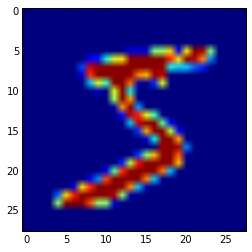

In [163]:
plt.imshow(X_train[0].reshape(28,28)) # This is what the image looks like

In [224]:
examples = [54229,17473, 6642, 29232, 38150, 2186, 58443, 15689, 14413, 14662]

In [225]:
from mpl_toolkits.axes_grid1 import AxesGrid

def draw_examples_with_perturbation(examples, f):
    """Draw examples with provided perturbation f
    
    :param examples: list of examples
    :param f: transformation function with takes a 28x28 image
    and returns a 28x28 image
    """
    examples = [(e, n) for n, e in enumerate(examples)]
    grid = AxesGrid(plt.figure(figsize=(8,15)), 141,  # similar to subplot(141)
                        nrows_ncols=(len(examples), 2),
                        axes_pad=0.05,
                        label_mode="1",
                        )

    for examplenum,num in examples:
        image = X_train[examplenum].reshape(28,28)
        im = grid[2*num].imshow(image)
        im2 = grid[2*num+1].imshow(f(image))

#Perturbations
##Skewing

In [ ]:
from scipy.ndimage import interpolation
def skew(image):
    """Skew the image provided.

    Taken from StackOverflow:
    http://stackoverflow.com/a/33088550/4855984
    """
    image = image.reshape(28, 28)
    h, l = image.shape
    dl = np.random.normal(loc=10, scale=1)

    def mapping(lc):
        l, c = lc
        dec = (dl*(l-h))/h
        return l, c+dec
    return interpolation.geometric_transform(
        image, mapping, (h, l), order=5, mode='nearest')

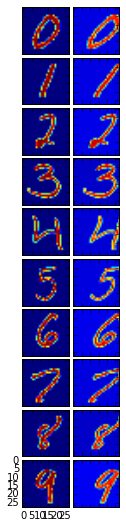

In [226]:
draw_examples_with_perturbation(examples, skew)

##Rotation

In [237]:
def rotate(image, d):
    """Rotate the image by d/180 degrees."""
    center = 0.5*np.array(image.shape)
    rot = np.array([[np.cos(d), np.sin(d)],[-np.sin(d), np.cos(d)]])
    offset = (center-center.dot(rot)).dot(np.linalg.inv(rot))
    return interpolation.affine_transform(
        image,
        rot,
        order=2,
        offset=-offset,
        cval=0.0, output=np.float32)

In [252]:
rotate_cw = lambda image: rotate(image, -(3*np.random.random()/5))
rotate_ccw = lambda image: rotate(image, 3*np.random.random()/5)

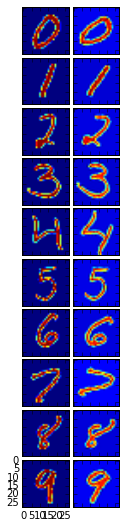

In [253]:
draw_examples_with_perturbation(examples, rotate_cw)

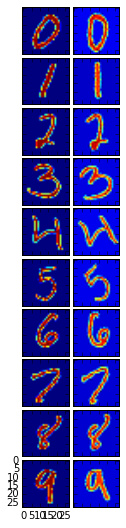

In [254]:
draw_examples_with_perturbation(examples, rotate_ccw)

##Noise

In [244]:
def noise(image, n=100):
    """Add noise by randomly changing n pixels"""
    indices = np.random.random(size=(n, 2))*28
    image = image.copy()
    for x, y in indices:
        x, y = int(x), int(y)
        image[x][y] = 0
    return image

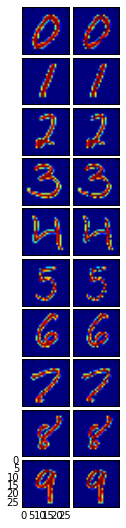

In [245]:
draw_examples_with_perturbation(examples, noise)